In [2]:
import os
os.listdir('/kaggle/input')
embeddings_path = "/kaggle/input/embeddings"
print(os.listdir(embeddings_path))

['speeches_with_embeddings.csv', 'speeches_embeddings_sentiment.csv', 'news_embeddings_sentiment.csv', 'news_with_embeddings.csv']


# Similarity algorithm efficiently 

In [3]:
import pandas as pd

speeches_embeddings = pd.read_csv(f"{embeddings_path}/speeches_with_embeddings.csv")
news_embeddings = pd.read_csv(f"{embeddings_path}/news_with_embeddings.csv")

# Display first few rows
print("News Data:")
print(news_embeddings.head())

print("\nSpeeches Data:")
print(speeches_embeddings.head())

News Data:
          Index                                               Link  \
0  1_01_12_2018  https://www.bbc.com/mundo/noticias-america-lat...   
1  2_01_12_2018  https://politica.expansion.mx/presidencia/2018...   
2  3_01_12_2018  https://oem.com.mx/elsoldemexico/mexico/en-don...   
3  4_01_12_2018  https://politica.expansion.mx/presidencia/2018...   
4  5_01_12_2018  https://www.eleconomista.com.mx/politica/Nicol...   

                                              Domain  \
0  BBC\nToma de protesta de AMLO: las 5 tradicion...   
1  Expansión Política\nAMLO rinde protesta y prom...   
2  El Sol de México\n¿Hay Ley Seca este 1 de dici...   
3  Expansión Política\nAMLO es un "líder persiste...   
4  El Economista\nNicolás Maduro llega a Palacio ...   

                                               Title        Date  \
0  Toma de protesta de AMLO: las 5 tradiciones qu...  2018-12-01   
1        AMLO rinde protesta y promete no reelegirse  2018-12-01   
2  ¿Hay Ley Seca este 1 de 

### Steps to redo the index so we can capture time-dependencies 

In [4]:
import pandas as pd
import numpy as np
import torch

# Convert date columns to datetime
news_embeddings['Date'] = pd.to_datetime(news_embeddings['Date'])
speeches_embeddings['date'] = pd.to_datetime(speeches_embeddings['date'])

# Check unique dates
print("Unique speech dates:", speeches_embeddings['date'].unique()[:5])
print("Unique news dates:", news_embeddings['Date'].unique()[:5])

# Sort both dataframes by date
news_embeddings = news_embeddings.sort_values(by='Date').reset_index(drop=True)
speeches_embeddings = speeches_embeddings.sort_values(by='date').reset_index(drop=True)

# check first dates
print("First speech date after sorting:", speeches_embeddings.iloc[0]['date'])
print("First news date after sorting:", news_embeddings.iloc[0]['Date'])

# Fix duplicate news indices
duplicate_mask = news_embeddings.duplicated(subset=['Index'], keep=False)
news_embeddings.loc[duplicate_mask, 'Index'] = (
    news_embeddings.loc[duplicate_mask].groupby('Index').cumcount().astype(str) + "_" +
    news_embeddings.loc[duplicate_mask, 'Index']
)

# Generate chunk IDs
speeches_embeddings['chunk_id'] = speeches_embeddings.groupby('speech_id').cumcount()
speeches_embeddings['chunk_id'] = "speech_" + speeches_embeddings['speech_id'].astype(str) + "_chunk_" + speeches_embeddings['chunk_id'].astype(str)

news_embeddings['chunk_id'] = news_embeddings.groupby('Index').cumcount()
news_embeddings['chunk_id'] = "news_" + news_embeddings['Index'].astype(str) + "_chunk_" + news_embeddings['chunk_id'].astype(str)

# Track chunk IDs for alignment
speech_tracking_df = speeches_embeddings[['speech_id', 'chunk_id', 'date']].reset_index(drop=True)
news_tracking_df = news_embeddings[['Index', 'chunk_id', 'Date']].reset_index(drop=True)

# Sort and format dates
speech_tracking_df = speech_tracking_df.sort_values(by=['date', 'speech_id']).reset_index(drop=True)
news_tracking_df = news_tracking_df.sort_values(by=['Date', 'Index']).reset_index(drop=True)

speech_tracking_df['date'] = speech_tracking_df['date'].dt.strftime('%Y-%m-%d')
news_tracking_df['Date'] = news_tracking_df['Date'].dt.strftime('%Y-%m-%d')

# Find common dates and filter
common_dates = set(speech_tracking_df['date']).intersection(set(news_tracking_df['Date']))
speech_tracking_df = speech_tracking_df[speech_tracking_df['date'].isin(common_dates)].reset_index(drop=True)
news_tracking_df = news_tracking_df[news_tracking_df['Date'].isin(common_dates)].reset_index(drop=True)

# Debugging: Print first few filtered dates
print("Filtered Speech Dates:", speech_tracking_df['date'].unique()[:5])
print("Filtered News Dates:", news_tracking_df['Date'].unique()[:5])

# Convert embeddings to NumPy arrays
def clean_and_convert_embeddings(embedding_str):
    """ Cleans and converts embedding strings to NumPy arrays. """
    if isinstance(embedding_str, str):
        cleaned_str = embedding_str.replace('[', '').replace(']', '').replace('\n', '')
        return np.array(cleaned_str.split(), dtype=float)
    elif isinstance(embedding_str, list) or isinstance(embedding_str, np.ndarray):
        return np.array(embedding_str, dtype=float)
    else:
        raise ValueError(f"Unexpected embedding format: {type(embedding_str)}")

speech_embeddings_list = speeches_embeddings['speech_embeddings'].apply(clean_and_convert_embeddings).tolist()
news_embeddings_list = news_embeddings['news_embeddings'].apply(clean_and_convert_embeddings).tolist()

# Stack into matrices
speech_matrix_2019 = np.vstack(speech_embeddings_list)
news_matrix_2019 = np.vstack(news_embeddings_list)

# Convert to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
speech_tensor_2019 = torch.tensor(speech_matrix_2019, dtype=torch.float32).to(device)
news_tensor_2019 = torch.tensor(news_matrix_2019, dtype=torch.float32).to(device)

# Debugging tensor shapes
print(f"✅ Speech Tensor Shape: {speech_tensor_2019.shape} | Device: {speech_tensor_2019.device}")
print(f"✅ News Tensor Shape: {news_tensor_2019.shape} | Device: {news_tensor_2019.device}")

# Retrieve first speech and news date
speech_date_first = speech_tracking_df.iloc[0]['date']
news_date_first = news_tracking_df.iloc[0]['Date']

# Check for date alignment
if speech_date_first == news_date_first:
    print(f"✅ Dates match: {speech_date_first}")
else:
    print(f"⚠️ Mismatch! Speech Date: {speech_date_first}, News Date: {news_date_first}")


Unique speech dates: <DatetimeArray>
['2024-01-09 00:00:00', '2024-01-08 00:00:00', '2024-01-07 00:00:00',
 '2024-01-06 00:00:00', '2024-01-05 00:00:00']
Length: 5, dtype: datetime64[ns]
Unique news dates: <DatetimeArray>
['2018-12-01 00:00:00', '2018-12-02 00:00:00', '2018-12-03 00:00:00',
 '2018-12-04 00:00:00', '2018-12-05 00:00:00']
Length: 5, dtype: datetime64[ns]
First speech date after sorting: 2018-12-04 00:00:00
First news date after sorting: 2018-12-01 00:00:00
Filtered Speech Dates: ['2018-12-04' '2018-12-05' '2018-12-06' '2018-12-07' '2018-12-10']
Filtered News Dates: ['2018-12-04' '2018-12-05' '2018-12-06' '2018-12-07' '2018-12-10']
✅ Speech Tensor Shape: torch.Size([174818, 768]) | Device: cpu
✅ News Tensor Shape: torch.Size([42822, 768]) | Device: cpu
✅ Dates match: 2018-12-04


In [5]:
# Fix mismatched sizes by taking the min length
min_rows = min(len(speech_tensor_2019), len(news_tensor_2019))
speech_tensor_2019 = speech_tensor_2019[:min_rows]
news_tensor_2019 = news_tensor_2019[:min_rows]

speech_tracking_df = speech_tracking_df.iloc[:min_rows].reset_index(drop=True)
news_tracking_df = news_tracking_df.iloc[:min_rows].reset_index(drop=True)

print(f"✅ After Fix: Speech Tensor Shape {speech_tensor_2019.shape}, News Tensor Shape {news_tensor_2019.shape}")

✅ After Fix: Speech Tensor Shape torch.Size([42822, 768]), News Tensor Shape torch.Size([42822, 768])


In [9]:
def compute_cosine_similarity(speech_tensor, news_tensor, speech_tracking_df, news_tracking_df):
    import time
    
    start_time = time.time()

    # Ensure tensors and DataFrames have the same length
    min_rows = min(len(speech_tensor), len(news_tensor), len(speech_tracking_df), len(news_tracking_df))

    print(f"✅ Matching Sizes: min_rows={min_rows}, Speech Tensor={len(speech_tensor)}, News Tensor={len(news_tensor)}")
    print(f"✅ Speech DF={len(speech_tracking_df)}, News DF={len(news_tracking_df)}")

    speech_tensor = speech_tensor[:min_rows]
    news_tensor = news_tensor[:min_rows]
    speech_tracking_df = speech_tracking_df.iloc[:min_rows].reset_index(drop=True)
    news_tracking_df = news_tracking_df.iloc[:min_rows].reset_index(drop=True)

    # Compute cosine similarity
    cosine_similarities = torch.nn.functional.cosine_similarity(speech_tensor, news_tensor)

    elapsed_time = time.time() - start_time
    print(f"✅ Cosine Similarity Computed! Shape: {cosine_similarities.shape}")
    print(f"⏳ Elapsed Time: {elapsed_time:.2f} seconds")

    # Store results safely
    similarities_final = []
    for i in range(min_rows):
        try:
            similarities_final.append({
                'speech_index': speech_tracking_df.iloc[i]['chunk_id'],
                'news_index': news_tracking_df.iloc[i]['chunk_id'],
                'cosine_similarity': cosine_similarities[i].item()
            })
        except IndexError as e:
            print(f"⚠️ Index Error at i={i}: {e}")
            break  # Stop processing to avoid crashing

    return similarities_final


In [10]:
similarities = compute_cosine_similarity(speech_tensor_2019, news_tensor_2019, speech_tracking_df, news_tracking_df)


✅ Matching Sizes: min_rows=34974, Speech Tensor=42822, News Tensor=42822
✅ Speech DF=42822, News DF=34974
✅ Cosine Similarity Computed! Shape: torch.Size([34974])
⏳ Elapsed Time: 0.21 seconds


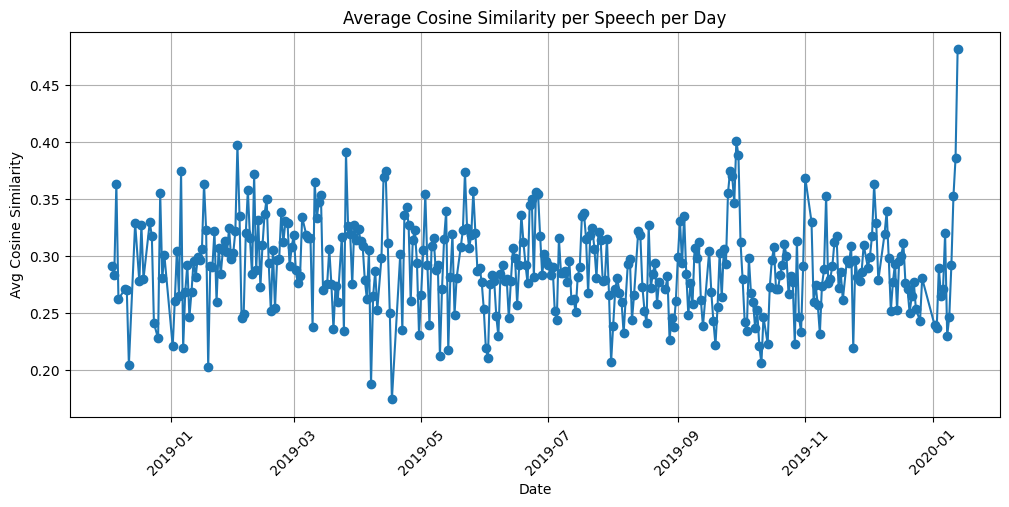

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def compute_and_plot_avg_similarity(similarities_final, speech_tracking_df):
    # Convert results to DataFrame
    similarity_df = pd.DataFrame(similarities_final)
    
    # Merge with speech_tracking_df to get speech dates
    similarity_df = similarity_df.merge(speech_tracking_df[['chunk_id', 'date']], 
                                        left_on='speech_index', 
                                        right_on='chunk_id', 
                                        how='left')

    # Compute average similarity per day
    daily_avg_similarity = similarity_df.groupby('date')['cosine_similarity'].mean().reset_index()

    # Convert date to datetime for plotting
    daily_avg_similarity['date'] = pd.to_datetime(daily_avg_similarity['date'])

    # Sort by date
    daily_avg_similarity = daily_avg_similarity.sort_values(by='date')

    # **Step 2: Plot the Time-Series Trend**
    plt.figure(figsize=(12, 5))
    plt.plot(daily_avg_similarity['date'], daily_avg_similarity['cosine_similarity'], marker='o', linestyle='-')

    plt.xlabel('Date')
    plt.ylabel('Avg Cosine Similarity')
    plt.title('Average Cosine Similarity per Speech per Day')
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability
    plt.show()
    
    return daily_avg_similarity  # Return the DataFrame for further analysis if needed

# **Usage**
daily_avg_similarity_df = compute_and_plot_avg_similarity(similarities, speech_tracking_df)


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def compute_similarity_stats(similarities_final, speech_tracking_df):
    # Convert results to DataFrame
    similarity_df = pd.DataFrame(similarities_final)
    
    # Merge with speech_tracking_df to get speech dates
    similarity_df = similarity_df.merge(speech_tracking_df[['chunk_id', 'date']], 
                                        left_on='speech_index', 
                                        right_on='chunk_id', 
                                        how='left')

    # Compute statistics per day
    daily_stats = similarity_df.groupby('date')['cosine_similarity'].agg(
        avg_similarity='mean',
        min_similarity='min',
        max_similarity='max',
        std_similarity='std'
    ).reset_index()

    # Convert date to datetime
    daily_stats['date'] = pd.to_datetime(daily_stats['date'])

    # Sort by date
    daily_stats = daily_stats.sort_values(by='date')

    return daily_stats

# **Usage**
daily_similarity_stats = compute_similarity_stats(similarities, speech_tracking_df)

# Display first few rows
print(daily_similarity_stats.head())


        date  avg_similarity  min_similarity  max_similarity  std_similarity
0 2018-12-04        0.291144        0.064080        0.431181        0.069889
1 2018-12-05        0.283670        0.104979        0.445631        0.069972
2 2018-12-06        0.363670        0.070711        0.446436        0.059546
3 2018-12-07        0.262347        0.052995        0.417910        0.074456
4 2018-12-10        0.270945        0.002188        0.460928        0.084736


### Idea: do PCA for embeddings so I have around 90% of information in three dimensions instead of 768. 

# Cosine similarity 

In [ ]:
# Cosine Similarity Calculation
torch.save(news_tensor_2019.cpu(), '/kaggle/working/news_tensor_2019.pt')
torch.save(speech_tensor_2019.cpu(), '/kaggle/working/speech_tensor_2019.pt')

news_tensor_2019 = torch.load('/kaggle/working/news_tensor_2019.pt')
speech_tensor_2019 = torch.load('/kaggle/working/speech_tensor_2019.pt')

def compute_batch_cosine_similarity(embedding, batch_embeddings):
    """
    Computes cosine similarity between a single embedding and a batch of embeddings.
    """
    embedding = embedding.unsqueeze(0) if embedding.dim() == 1 else embedding
    batch_embeddings = batch_embeddings / batch_embeddings.norm(dim=1, keepdim=True)  # Normalize
    embedding = embedding / embedding.norm(dim=1, keepdim=True)
    return torch.mm(batch_embeddings, embedding.T).squeeze()

def compute_similarities_in_chunks(speech_tensor, news_tensor, chunk_size=1000):
    """
    Computes cosine similarity in chunks to manage GPU memory efficiently.
    """
    similarities = []
    for i in range(0, len(news_tensor), chunk_size):
        chunk = news_tensor[i:i + chunk_size].cuda()  # Load only the chunk to GPU
        cosine_sim = compute_batch_cosine_similarity(speech_tensor, chunk)
        similarities.extend(cosine_sim.cpu().tolist())
        del chunk  # Free memory
        torch.cuda.empty_cache()
    return similarities


In [ ]:
# Batch processing with index tracking
batch_size = 100  
num_speeches = len(speech_tensor_2019)

start_time = time.time()
processed_batches = 0  

for batch_start in range(0, num_speeches, batch_size):
    batch_end = min(batch_start + batch_size, num_speeches)

    speech_batch = speech_tensor_2019[batch_start:batch_end].cuda()
    
    similarities_final = []
    
    for idx, speech_embedding_final in enumerate(speech_batch):
        cosine_similarities = compute_similarities_in_chunks(speech_embedding_final, news_tensor_2019)
        
        for news_id, sim_value in enumerate(cosine_similarities):
            similarities_final.append({
                'speech_index': speech_tracking_df.iloc[batch_start + idx]['chunk_id'],  
                'news_index': news_tracking_df.iloc[news_id]['chunk_id'],  
                'cosine_similarity': sim_value
            })

    similarities_df_final = pd.DataFrame(similarities_final)
    similarities_df_final.to_parquet(f'/kaggle/working/similarities_final_batch_{batch_start}.parquet')
    
    del speech_batch
    torch.cuda.empty_cache()
    
    processed_batches += 1
    if processed_batches % 10 == 0:
        elapsed_time = time.time() - start_time
        print(f"Processed {processed_batches * batch_size}/{num_speeches} speeches. Elapsed time: {elapsed_time:.2f}s")

print("✅ Finished computing cosine similarities.")

# Past functions 

In [ ]:
#experiment with new cosine similarity function 

import torch
import pandas as pd
import time

# Step 1: Save tensors to disk in CPU memory (if not already saved)
torch.save(news_tensor_final.cpu(), '/kaggle/working/news_tensor_final.pt')
torch.save(speech_tensor_final.cpu(), '/kaggle/working/speech_tensor_final.pt')

# Step 2: Load news tensor once, but keep it on the CPU
news_tensor_final = torch.load('/kaggle/working/news_tensor_final.pt')
speech_tensor_final = torch.load('/kaggle/working/speech_tensor_final.pt')

# Step 3: Define the chunked computation for cosine similarity
def compute_batch_cosine_similarity(embedding, batch_embeddings):
    embedding = embedding.unsqueeze(0) if embedding.dim() == 1 else embedding
    batch_embeddings = batch_embeddings / batch_embeddings.norm(dim=1, keepdim=True) #to avoid normalizing them manually in case theyre already normalized 
    embedding = embedding / embedding.norm(dim=1, keepdim=True)
    return torch.mm(batch_embeddings, embedding.T).squeeze()

def compute_similarities_in_chunks(speech_tensor, news_tensor, chunk_size=1000):
    similarities = []
    for i in range(0, len(news_tensor), chunk_size):
        chunk = news_tensor[i:i + chunk_size].cuda()  # Load only the chunk onto GPU
        cosine_sim = compute_batch_cosine_similarity(speech_tensor, chunk)
        similarities.extend(cosine_sim.cpu().tolist())
        del chunk  # Free memory
        torch.cuda.empty_cache()
    return similarities

# Step 4: Process the speech tensor in batches and save intermediate results
batch_size = 100  # Adjust batch size as needed
num_speeches = len(speech_tensor_final)
start_time = time.time()
processed_batches = 0  # Counter for batches processed

# Step 5: Use indices for tracking the news and speech tensors
for batch_start in range(0, num_speeches, batch_size):
    batch_end = min(batch_start + batch_size, num_speeches)

    # Load a batch of speech embeddings to the GPU
    speech_batch = torch.load('/kaggle/working/speech_tensor_final.pt')[batch_start:batch_end].cuda()
    
    similarities_final = []
    
    for idx, speech_embedding_final in enumerate(speech_batch):
        cosine_similarities = compute_similarities_in_chunks(speech_embedding_final, news_tensor_final)
        
        # Store results with the indices
        for news_id, sim_value in enumerate(cosine_similarities):
            similarities_final.append({
                'speech_index': speech_indices_final[batch_start + idx],  # Use the speech index
                'news_index': news_indices_final[news_id],  # Use the news index
                'cosine_similarity': sim_value
            })

    # Save intermediate results to disk with the indices included
    similarities_df_final = pd.DataFrame(similarities_final)
    similarities_df_final.to_parquet(f'/kaggle/working/similarities_final_batch_{batch_start}.parquet')
    
    # Free up GPU memory
    del speech_batch
    torch.cuda.empty_cache()
    
    # Increment and check if 1000 batches processed
    processed_batches += 1
    if processed_batches % 100 == 0:
        elapsed_time = time.time() - start_time
        print(f"Processed {processed_batches * batch_size}/{num_speeches} speeches. Elapsed time: {elapsed_time:.2f}s")

print("Finished computing cosine similarities.")


In [ ]:
print(similarities_df_final.columns)


In [ ]:
import pandas as pd

# Assuming similarities_df_final already contains 'speech_index', 'news_index', and 'cosine_similarity'

# Extract date from speech_index and news_index while handling the day-first warning
similarities_df_final['speech_date'] = pd.to_datetime(
    similarities_df_final['speech_index'].apply(lambda x: x.split('_')[1] + '-' + x.split('_')[2] + '-' + x.split('_')[3]),
    dayfirst=True
)

similarities_df_final['news_date'] = pd.to_datetime(
    similarities_df_final['news_index'].apply(lambda x: x.split('_')[1] + '-' + x.split('_')[2] + '-' + x.split('_')[3]),
    dayfirst=True
)

# Retain relevant columns
print(similarities_df_final.head())
print(similarities_df_final.columns.tolist())  # See exact column names
print(len(similarities_df_final['news_date']))

In [ ]:
print(similarities_df_final['news_date'].nunique())  # Should be >1
print(similarities_df_final['news_date'].unique())   # See unique dates


In [ ]:
similarities_df_final.columns = similarities_df_final.columns.str.strip() 
filtered_df = similarities_df_final  # Ensure it includes news_date
print(filtered_df.columns)

In [ ]:
print(filtered_df['news_date'].isna().sum())  # Check for missing values
print(filtered_df['news_date'].dtype)

In [ ]:
summary_stats = (
    filtered_df.groupby('news_date')
    .agg(avg_cosine_similarity=('cosine_similarity', 'mean'),
         max_cosine_similarity=('cosine_similarity', 'max'),
         min_cosine_similarity=('cosine_similarity', 'min'),
         num_pairs=('cosine_similarity', 'count'))
    .reset_index()
)
summary_stats['news_date'] = pd.to_datetime(summary_stats['news_date'])
print(summary_stats)

In [ ]:
print(filtered_df['news_date'].nunique())  # Number of unique dates
print(filtered_df['news_date'].unique()[:10])  # Show first 10 unique dates


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(summary_stats['news_date'], summary_stats['avg_cosine_similarity'], label='Avg Cosine Similarity', color='b')
plt.plot(summary_stats['news_date'], summary_stats['max_cosine_similarity'], label='Max Cosine Similarity', color='g')
plt.xlabel('News Date')
plt.ylabel('Cosine Similarity')
plt.title('Average and Maximum Cosine Similarity Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
print(filtered_df.columns)
print(filtered_df.dtypes)

speech_summary_df = filtered_df.groupby('speech_index').agg(
    avg_cosine_similarity=('cosine_similarity', 'mean'),
    num_news_articles=('cosine_similarity', 'count')  # Number of news articles linked to the speech
).reset_index()
speech_summary_df = speech_summary_df.merge(filtered_df[['speech_index', 'speech_date']].drop_duplicates(), on='speech_index', how='left')

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(x='speech_date', y='avg_cosine_similarity', data=speech_summary_df, marker='o')
plt.xlabel("Speech Date")
plt.ylabel("Average Cosine Similarity Per Speech")
plt.title("Average Cosine Similarity Over Time (Per Speech)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()




In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure news_date is in datetime format
filtered_df['news_date'] = pd.to_datetime(filtered_df['news_date'])
plt.figure(figsize=(12, 6))
sns.lineplot(x='news_date', y='avg_cosine_similarity', data=filtered_df, marker='o')
plt.xlabel("Date")
plt.ylabel("Average Cosine Similarity")
plt.title("Average Cosine Similarity Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 6))
sns.lineplot(x='news_date', y='num_pairs', data=filtered_df, marker='o', color='red')
plt.xlabel("Date")
plt.ylabel("Number of Pairs")
plt.title("Number of Speech-News Pairs Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# Code to calculate cosine similarity and tries to solve the ram issue efficiently. 

In [ ]:
import torch
import pandas as pd
import time

# Step 1: Save tensors to disk in CPU memory (if not already saved)
torch.save(news_tensor_2019.cpu(), '/kaggle/working/news_tensor_2019.pt')
torch.save(speech_tensor_2019.cpu(), '/kaggle/working/speech_tensor_2019.pt')

# Step 2: Load news tensor once, but keep it on the CPU
news_tensor_2019 = torch.load('/kaggle/working/news_tensor_2019.pt')
speech_tensor_2019 = torch.load('/kaggle/working/speech_tensor_2019.pt')

# Step 3: Define the chunked computation for cosine similarity
def compute_batch_cosine_similarity(embedding, batch_embeddings):
    embedding = embedding.unsqueeze(0) if embedding.dim() == 1 else embedding
    #batch_embeddings = batch_embeddings / batch_embeddings.norm(dim=1, keepdim=True) to avoid normalizing them manually in case theyre already normalized 
    #embedding = embedding / embedding.norm(dim=1, keepdim=True)
    return torch.mm(batch_embeddings, embedding.T).squeeze()

def compute_similarities_in_chunks(speech_tensor, news_tensor, chunk_size=1000):
    similarities = []
    for i in range(0, len(news_tensor), chunk_size):
        chunk = news_tensor[i:i + chunk_size].cuda()  # Load only the chunk onto GPU
        cosine_sim = compute_batch_cosine_similarity(speech_tensor, chunk)
        similarities.extend(cosine_sim.cpu().tolist())
        del chunk  # Free memory
        torch.cuda.empty_cache()
    return similarities

# Step 4: Process the speech tensor in batches and save intermediate results
batch_size = 100  # Adjust batch size as needed
num_speeches = len(speech_tensor_2019)
start_time = time.time()
processed_batches = 0  # Counter for batches processed

# Step 5: Use indices for tracking the news and speech tensors
for batch_start in range(0, num_speeches, batch_size):
    batch_end = min(batch_start + batch_size, num_speeches)

    # Load a batch of speech embeddings to the GPU
    speech_batch = torch.load('/kaggle/working/speech_tensor_2019.pt')[batch_start:batch_end].cuda()
    
    similarities_2019 = []
    
    for idx, speech_embedding_2019 in enumerate(speech_batch):
        cosine_similarities = compute_similarities_in_chunks(speech_embedding_2019, news_tensor_2019)
        
        # Store results with the indices
        for news_id, sim_value in enumerate(cosine_similarities):
            similarities_2019.append({
                'speech_index': speech_indices_2019[batch_start + idx],  # Use the speech index
                'news_index': news_indices_2019[news_id],  # Use the news index
                'cosine_similarity': sim_value
            })

    # Save intermediate results to disk with the indices included
    similarities_df_2019 = pd.DataFrame(similarities_2019)
    similarities_df_2019.to_parquet(f'/kaggle/working/similarities_2019_batch_{batch_start}.parquet')
    
    # Free up GPU memory
    del speech_batch
    torch.cuda.empty_cache()
    
    # Increment and check if 1000 batches processed
    processed_batches += 1
    if processed_batches % 100 == 0:
        elapsed_time = time.time() - start_time
        print(f"Processed {processed_batches * batch_size}/{num_speeches} speeches. Elapsed time: {elapsed_time:.2f}s")

print("Finished computing cosine similarities.")


In [ ]:
import pandas as pd
import glob
import matplotlib.pyplot as plt 
# Step 1: Load all parquet files and combine them into one DataFrame
file_paths = glob.glob('/kaggle/working/similarities_2019_batch_*.parquet')
similarities_df_2019 = pd.concat([pd.read_parquet(f) for f in file_paths], ignore_index=True)

# Check the data after loading
print(similarities_df_2019.head())

In [ ]:
#align similarities

# Assuming similarities_df_2019 already contains the 'speech_index' and 'news_index'

import pandas as pd

# Assuming similarities_df_2019 already contains 'speech_index', 'news_index', and 'cosine_similarity'

# Step 1: Extract date from speech_index and news_index while handling the day-first warning
similarities_df_2019['speech_date'] = pd.to_datetime(similarities_df_2019['speech_index'].apply(lambda x: x.split('_')[1] + '-' + x.split('_')[2] + '-' + x.split('_')[3]), dayfirst=True)
similarities_df_2019['news_date'] = pd.to_datetime(similarities_df_2019['news_index'].apply(lambda x: x.split('_')[1] + '-' + x.split('_')[2] + '-' + x.split('_')[3]), dayfirst=True)

# Step 2: Retain the speech_date, news_date, cosine_similarity, and both indexes without aggregation
# No need to group here, just keep them all in the DataFrame
print(similarities_df_2019.head())

In [ ]:
# Group by speech_date and news_date, then aggregate cosine_similarity (e.g., mean or max)
grouped_similarities = similarities_df_2019.groupby(['speech_date', 'news_date'])['cosine_similarity'].agg(['mean', 'max', 'count']).reset_index()

# Rename columns for clarity
grouped_similarities.rename(columns={'mean': 'avg_cosine_similarity', 'max': 'max_cosine_similarity', 'count': 'num_pairs'}, inplace=True)

# Check the result
print(grouped_similarities.head())


In [ ]:
# Filter speeches that occurred on or before the news date
filtered_df = similarities_df_2019[similarities_df_2019['speech_date'] <= similarities_df_2019['news_date']]

# Sort by news_date and speech_date for easier visualization
filtered_df = filtered_df.sort_values(['news_date', 'speech_date']).reset_index(drop=True)
# Group by news_date, but keep all columns and concatenate the results
grouped_df = (
    filtered_df.groupby('news_date')
    .apply(lambda x: x.reset_index(drop=True))
    .reset_index(drop=True)
)

# Display the result
print(grouped_df.head(10))



In [ ]:
# Summary statistics grouped by news_date
summary_stats = (
    filtered_df.groupby('news_date')
    .agg(avg_cosine_similarity=('cosine_similarity', 'mean'),
         max_cosine_similarity=('cosine_similarity', 'max'),
         min_cosine_similarity=('cosine_similarity', 'min'),
         num_pairs=('cosine_similarity', 'count'))
    .reset_index()
)
print(summary_stats.head())


In [ ]:
import matplotlib.pyplot as plt

# Convert 'news_date' to datetime if it isn't already
summary_stats['news_date'] = pd.to_datetime(summary_stats['news_date'])

# Plot avg_cosine_similarity over time
plt.figure(figsize=(12, 6))
plt.plot(summary_stats['news_date'], summary_stats['avg_cosine_similarity'], label='Avg Cosine Similarity', color='b')
plt.plot(summary_stats['news_date'], summary_stats['max_cosine_similarity'], label='Max Cosine Similarity', color='g')
plt.xlabel('News Date')
plt.ylabel('Cosine Similarity')
plt.title('Average and Maximum Cosine Similarity Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot num_pairs over time
plt.figure(figsize=(12, 6))
plt.bar(summary_stats['news_date'], summary_stats['num_pairs'], color='orange', alpha=0.7)
plt.xlabel('News Date')
plt.ylabel('Number of Pairs')
plt.title('Number of Speech-News Pairs Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
import os

# Define directory to save files
save_dir = "saved_data"
os.makedirs(save_dir, exist_ok=True)

# Save as CSV
summary_stats.to_csv(os.path.join(save_dir, "summary_stats.csv"), index=False)
filtered_df.to_csv(os.path.join(save_dir, "filtered_df.csv"), index=False)
grouped_df.to_csv(os.path.join(save_dir, "grouped_similarities.csv"), index=False)


In [ ]:
import os
os.listdir('/kaggle/input')
embeddings_path = "/kaggle/input/cosine-similarity-df"
print(os.listdir(embeddings_path))

In [ ]:
import pandas as pd 

grouped_similarities = pd.read_csv(f"{embeddings_path}/grouped_similarities.csv")
filtered_df = pd.read_csv(f"{embeddings_path}/filtered_df.csv")
summary_stats = pd.read_csv(f"{embeddings_path}/summary_stats.csv")

In [ ]:
print(grouped_similarities.head())
print(filtered_df.head())
print(summary_stats.head())

In [ ]:
print(summary_stats.head())

In [ ]:
#in this section i can normalize similarity scores and consider the amount of news-speeches pairs. 
# Min-Max normalization function
#def min_max_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Normalize cosine_similarity column in grouped_similarities
#grouped_similarities["normalized_cosine_similarity"] = min_max_normalize(grouped_similarities["cosine_similarity"])

In [ ]:
from scipy.stats import zscore

# Compute Z-score normalization for cosine similarities
grouped_similarities["z_normalized_similarity"] = grouped_similarities["cosine_similarity"].transform(zscore)


In [ ]:
normalized_summary = grouped_similarities.groupby("speech_date")["z_normalized_similarity"].agg(
    avg_similarity="mean",
    max_similarity="max",
    min_similarity="min"
).reset_index()


In [ ]:
print(normalized_summary)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(normalized_summary["speech_date"], normalized_summary["avg_similarity"], label="Avg Similarity (Z-Score)", color="blue", linestyle="-")
plt.plot(normalized_summary["speech_date"], normalized_summary["max_similarity"], label="Max Similarity (Z-Score)", color="red", linestyle="--")
plt.plot(normalized_summary["speech_date"], normalized_summary["min_similarity"], label="Min Similarity (Z-Score)", color="green", linestyle=":")

plt.xlabel("Speech Date")
plt.ylabel("Z-Score Normalized Similarity")
plt.title("Normalized Similarity Trends Over Time (Z-Score)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
# Plot the normalized similarity metrics over time
plt.figure(figsize=(12, 6))

plt.plot(normalized_summary["speech_date"], normalized_summary["avg_similarity"], label="Avg Similarity", color="blue", linestyle="-")
plt.plot(normalized_summary["speech_date"], normalized_summary["max_similarity"], label="Max Similarity", color="red", linestyle="--")
plt.plot(normalized_summary["speech_date"], normalized_summary["min_similarity"], label="Min Similarity", color="green", linestyle=":")

# Formatting the plot
plt.xlabel("Speech Date")
plt.ylabel("Normalized Cosine Similarity")
plt.title("Normalized Similarity Trends Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


### The idea now, watching at the images, is that I need to build a score (similarity score or sentiment score) between speeches and news articles. The thing is that there are a lot of paragraphs similar to news articles, then it is interesting to create a measure for article similarity. Or compute another measure for articles. 
Article measure = sentiment score * similarity score 
I can do this and then see ways to improve it or change it. 


In [ ]:
#sentiment analysis 
!pip install transformers torch --quiet




In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load the pre-trained SaBERT model and tokenizer
MODEL_NAME = "VerificadoProfesional/SaBERT-Spanish-Sentiment-Analysis"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


In [ ]:
def predict_sentiment(text):
    """
    Predicts sentiment for a given chunk of text using SaBERT.
    """
    if not isinstance(text, str) or len(text.strip()) == 0:
        return "Neutral"  # Handle empty cases

    # Tokenize the chunk (keeping your structure intact)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Get the model's prediction
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    
    return "Positive" if predicted_class == 1 else "Negative"


In [ ]:
import time
from tqdm import tqdm  # For progress bar

# Define the prediction function with time and progress tracking
def predict_sentiment(text, start_time, processed_count, total_chunks):
    """
    Predicts sentiment for a given chunk of text using SaBERT.
    Also tracks time taken for each batch of 1000 processed chunks.
    """
    if not isinstance(text, str) or len(text.strip()) == 0:
        return "Neutral"  # Handle empty cases

    # Tokenize the chunk (keeping your structure intact)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Get the model's prediction
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    
    sentiment = "Positive" if predicted_class == 1 else "Negative"

    # Update progress and time estimation every 1000 chunks
    processed_count += 1
    if processed_count % 10000 == 0 or processed_count == total_chunks:
        elapsed_time = time.time() - start_time
        time_per_batch = elapsed_time / processed_count
        estimated_time_left = (total_chunks - processed_count) * time_per_batch
        print(f"Processed {processed_count}/{total_chunks} chunks.")
        print(f"Elapsed Time: {elapsed_time:.2f} seconds.")
        print(f"Estimated Time Left: {estimated_time_left:.2f} seconds.")
        print(f"Time per 1000 Chunks: {time_per_batch * 1000:.2f} seconds.")
    
    return sentiment, processed_count


# Function to process chunks with time updates and estimations
def process_with_time_estimation(df, chunk_column, sentiment_column):
    """
    Processes the chunks of text, applies sentiment analysis, 
    and tracks time for every 1000 processed batches.
    """
    start_time = time.time()  # Start timer for the entire process
    total_chunks = len(df)  # Total number of chunks to process
    processed_count = 0  # Counter for processed chunks

    # Using tqdm for progress bar
    for idx, row in tqdm(df.iterrows(), total=total_chunks, desc="Processing Chunks"):
        # Apply sentiment analysis with time updates
        sentiment, processed_count = predict_sentiment(row[chunk_column], start_time, processed_count, total_chunks)
        df.at[idx, sentiment_column] = sentiment

    # Final message after processing
    total_elapsed_time = time.time() - start_time
    print(f"\nProcessing complete! Total time: {total_elapsed_time:.2f} seconds.")
    return df


In [ ]:
# Applying sentiment analysis to speech_chunks
speeches_embeddings = process_with_time_estimation(speeches_embeddings, 'speech_chunks', 'speech_sentiment')


In [ ]:
print(speeches_embeddings.head())

In [ ]:
speeches_embeddings.to_csv(os.path.join(save_dir, "speeches_embeddings_sentiment.csv"), index=False)

In [ ]:
import time
from tqdm import tqdm

def predict_sentiment(text):
    """
    Predicts sentiment for a given chunk of text using SaBERT.
    """
    if not isinstance(text, str) or len(text.strip()) == 0:
        return "Neutral"  # Handle empty cases

    # Tokenize the chunk
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Get the model's prediction
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    
    return "Positive" if predicted_class == 1 else "Negative"

def process_news_sentiments(news_embeddings, chunk_column='news_chunks', sentiment_column='news_sentiment'):
    """
    Processes sentiment for the news dataset with progress tracking and estimated time updates.
    """
    start_time = time.time()
    total_chunks = len(news_embeddings)
    
    for idx, row in tqdm(news_embeddings.iterrows(), total=total_chunks, desc="Processing News Sentiments"):
        # Run sentiment analysis
        news_embeddings.at[idx, sentiment_column] = predict_sentiment(row[chunk_column])

        # Display time estimation every 1,000 rows
        if (idx + 1) % 1000 == 0 or (idx + 1) == total_chunks:
            elapsed_time = time.time() - start_time
            time_per_chunk = elapsed_time / (idx + 1)
            estimated_time_left = (total_chunks - (idx + 1)) * time_per_chunk
            print(f"Processed {idx + 1}/{total_chunks} chunks. Estimated Time Left: {estimated_time_left:.2f} seconds.")

    total_time = time.time() - start_time
    print(f"\nProcessing complete! Total time: {total_time:.2f} seconds.")
    return news_embeddings



In [ ]:
print(news_embeddings.columns)

In [ ]:
# Applying sentiment analysis to news_chunks
news_embeddings = process_news_sentiments(news_embeddings)


In [ ]:
news_embeddings.to_csv(os.path.join(save_dir, "news_embeddings_sentiment.csv"), index=False)

## new idea: leverage embeddings to infer topics and then use hellingber distance as a measure to capture the effect of speeches on media articles over time 

### now next steps to create the article's score based on embeddings and sentiment.  

In [ ]:
import os 
os.listdir('/kaggle/input')
embeddings_path = "/kaggle/input/embeddings"
print(os.listdir(embeddings_path))

In [ ]:
import pandas as pd
speeches_embeddings = pd.read_csv(f"{embeddings_path}/speeches_embeddings_sentiment.csv")
news_embeddings = pd.read_csv(f"{embeddings_path}/news_embeddings_sentiment.csv") 


In [ ]:
print(speeches_embeddings.head())
print(news_embeddings.head())
print(speeches_embeddings.columns)
print(news_embeddings.columns)

In [ ]:
!pip install BERTopic

In [ ]:
import ast
import re
import numpy as np

# Function to clean and convert embeddings stored as strings
def clean_and_convert(embedding_str):
    # Ensure it's a string and remove brackets, newlines, and extra spaces
    cleaned_str = embedding_str.replace('[', '').replace(']', '').replace('\n', ' ')
    return np.array(cleaned_str.split(), dtype=float)  # Convert to NumPy array of floats

# Apply function to clean both speech and news embeddings
speeches_embeddings['cleaned_speech_embeddings'] = speeches_embeddings['speech_embeddings'].apply(clean_and_convert)
news_embeddings['cleaned_news_embeddings'] = news_embeddings['news_embeddings'].apply(clean_and_convert)

# Print the first cleaned embeddings to verify
print("Cleaned Speech Embeddings (First Row):", speeches_embeddings['cleaned_speech_embeddings'].iloc[0][:10])
print("Cleaned News Embeddings (First Row):", news_embeddings['cleaned_news_embeddings'].iloc[0][:10])

In [ ]:
print(speeches_embeddings.head())
print(news_embeddings.head())
print(speeches_embeddings.columns)
print(news_embeddings.columns)


In [ ]:
# Stack embeddings into NumPy matrices
speech_matrix = np.vstack(speeches_embeddings['cleaned_speech_embeddings'].values)
news_matrix = np.vstack(news_embeddings['cleaned_news_embeddings'].values)

# Print shape to verify
print("Speech Embedding Matrix Shape:", speech_matrix.shape)
print("News Embedding Matrix Shape:", news_matrix.shape)


In [ ]:
import numpy as np
from bertopic import BERTopic

# Stack embeddings into NumPy matrices for speeches and news
speech_matrix = np.vstack(speeches_embeddings['cleaned_speech_embeddings'].values)
news_matrix = np.vstack(news_embeddings['cleaned_news_embeddings'].values)

# Print shape to verify
print("Speech Embedding Matrix Shape:", speech_matrix.shape)
print("News Embedding Matrix Shape:", news_matrix.shape)


In [ ]:
# Extract the content for speech and news for topic modeling
speech_documents = speeches_embeddings['speech_chunks'].values  # Chunks from speeches
news_documents = news_embeddings['news_chunks'].values  # Chunks from news articles


In [ ]:
# Convert speech matrix and news matrix to numpy arrays
speech_matrix = np.array(speech_matrix)
news_matrix = np.array(news_matrix)

In [ ]:
import numpy as np
import time
from bertopic import BERTopic

# Time the process
start_time = time.time()

# Convert speech matrix and news matrix to numpy arrays
speech_matrix = np.array(speech_matrix)
news_matrix = np.array(news_matrix)

# Initialize and fit BERTopic model on speech data
speech_topic_model = BERTopic(language="spanish")
speech_topics, _ = speech_topic_model.fit_transform(speech_documents, embeddings=speech_matrix)

# Store topics in speeches_embeddings DataFrame
speeches_embeddings["speech_topics"] = speech_topics

# Get the total number of speech topics
num_speech_topics = len(set(speech_topics)) - (1 if -1 in speech_topics else 0)

# Initialize and fit BERTopic model on news data
news_topic_model = BERTopic(language="spanish")
news_topics, _ = news_topic_model.fit_transform(news_documents, embeddings=news_matrix)

# Store topics in news_embeddings DataFrame
news_embeddings["news_topics"] = news_topics

# Get the total number of news topics
num_news_topics = len(set(news_topics)) - (1 if -1 in news_topics else 0)

# Print only the final topic counts
print(f"Total speech topics: {num_speech_topics}")
print(f"Total news topics: {num_news_topics}")

# Print the time taken for the whole process
end_time = time.time()
print(f"Time taken for topic modeling: {end_time - start_time:.2f} seconds")



### I'm starting the time analysis 

In [ ]:
import numpy as np
def hellinger(p, q):
    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))



In [ ]:
import numpy as np
import pandas as pd
from collections import Counter

# Define Hellinger Distance manually
def hellinger(p, q):
    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))

# Convert dates to datetime format
speeches_embeddings['date'] = pd.to_datetime(speeches_embeddings['date'])
news_embeddings['Date'] = pd.to_datetime(news_embeddings['Date'])

# Define the time window (e.g., 3 days before and 3 days after)
time_window = 1


In [ ]:
# Store results
hellinger_results = []

# Iterate over each speech
for index, speech_row in speeches_embeddings.iterrows():
    speech_date = speech_row['date']
    
    # Get news before the speech (e.g., 3 days before)
    news_before = news_embeddings[
        (news_embeddings['Date'] >= (speech_date - pd.Timedelta(days=time_window))) &
        (news_embeddings['Date'] < speech_date)
    ]
    
    # Get news after the speech (e.g., 3 days after)
    news_after = news_embeddings[
        (news_embeddings['Date'] > speech_date) &
        (news_embeddings['Date'] <= (speech_date + pd.Timedelta(days=time_window)))
    ]
    
    # Skip if not enough news data exists
    if len(news_before) < 5 or len(news_after) < 5:
        continue

    # Count topic occurrences before and after
    topics_before = Counter(news_before['news_topics'])
    topics_after = Counter(news_after['news_topics'])

    # Convert to probability distributions (normalized frequency of topics)
    all_topics = list(set(topics_before.keys()) | set(topics_after.keys()))
    
    prob_before = np.array([topics_before.get(topic, 0) for topic in all_topics], dtype=float)
    prob_after = np.array([topics_after.get(topic, 0) for topic in all_topics], dtype=float)
    
    # Normalize to make them probability distributions
    prob_before /= prob_before.sum()
    prob_after /= prob_after.sum()

    # Compute Hellinger Distance
    distance = hellinger(prob_before, prob_after)
    
    # Store results
    hellinger_results.append({
        'speech_id': speech_row['speech_id'],
        'speech_date': speech_date,
        'hellinger_distance': distance
    })

# Convert to DataFrame for analysis
hellinger_df = pd.DataFrame(hellinger_results)

# Print the first few results
print(hellinger_df.head())


In [ ]:
# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(hellinger_df['speech_date'], hellinger_df['hellinger_distance'], marker='o', linestyle='-')
plt.xlabel("Speech Date")
plt.ylabel("Hellinger Distance (Topic Change)")
plt.title("Effect of Speeches on News Coverage Over Time")
plt.xticks(rotation=45)
plt.show()

### Unified BERTopics 

In [ ]:
from bertopic import BERTopic
import pandas as pd

# Merge speech and news data
combined_texts = list(speeches_embeddings['speech_chunks']) + list(news_embeddings['news_chunks'])
combined_dates = list(speeches_embeddings['date']) + list(news_embeddings['Date'])

# Fit BERTopic on combined data
topic_model = BERTopic(nr_topics=100)
topics, probs = topic_model.fit_transform(combined_texts)

# Assign topics back to each dataset
num_speeches = len(speeches_embeddings)
speeches_embeddings['topic'] = topics[:num_speeches]
news_embeddings['topic'] = topics[num_speeches:]

# Store topic information
topic_info = topic_model.get_topic_info()
print(topic_info.head(10))

In [ ]:
import numpy as np
from collections import Counter

# Define Hellinger Distance function
def hellinger(p, q):
    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))

# Convert dates to datetime
speeches_embeddings['date'] = pd.to_datetime(speeches_embeddings['date'])
news_embeddings['Date'] = pd.to_datetime(news_embeddings['Date'])

# Define time window (e.g., 3 days before and after)
time_window = 4 

hellinger_results = []

# Iterate over each speech
for _, speech_row in speeches_embeddings.iterrows():
    speech_date = speech_row['date']
    
    # Get news before the speech
    news_before = news_embeddings[
        (news_embeddings['Date'] >= (speech_date - pd.Timedelta(days=time_window))) &
        (news_embeddings['Date'] < speech_date)
    ]
    
    # Get news after the speech
    news_after = news_embeddings[
        (news_embeddings['Date'] > speech_date) &
        (news_embeddings['Date'] <= (speech_date + pd.Timedelta(days=time_window)))
    ]
    
    # Skip if not enough news data exists
    if len(news_before) < 5 or len(news_after) < 5:
        continue

    # Count topic occurrences before and after
    topics_before = Counter(news_before['topic'])
    topics_after = Counter(news_after['topic'])

    # Convert to probability distributions
    all_topics = list(set(topics_before.keys()) | set(topics_after.keys()))
    
    prob_before = np.array([topics_before.get(topic, 0) for topic in all_topics], dtype=float)
    prob_after = np.array([topics_after.get(topic, 0) for topic in all_topics], dtype=float)
    
    # Normalize
    prob_before /= prob_before.sum()
    prob_after /= prob_after.sum()

    # Compute Hellinger Distance
    distance = hellinger(prob_before, prob_after)
    
    # Store results
    hellinger_results.append({
        'speech_id': speech_row['speech_id'],
        'speech_date': speech_date,
        'hellinger_distance': distance
    })

# Convert to DataFrame
hellinger_df = pd.DataFrame(hellinger_results)

# Print first few results
print(hellinger_df.head())


In [ ]:
# Check column names in both dataframes
print(speeches_embeddings.columns)
print(hellinger_df.columns)


In [ ]:
# Ensure the 'date' column exists in speeches_embeddings dataframe
speeches_embeddings.rename(columns={'Date': 'date'}, inplace=True)


In [ ]:
# Rename 'speech_date' to 'date' in hellinger_df
hellinger_df.rename(columns={'speech_date': 'date'}, inplace=True)

# Now merge the dataframes
speech_impact_df = speeches_embeddings.merge(hellinger_df, on=['speech_id', 'date'])


In [ ]:
print(prob_before)
print(prob_after)


In [ ]:
#The idea here is to measure speech impact
import seaborn as sns
import matplotlib.pyplot as plt

# Merge Hellinger Distance with speech topics
speech_impact_df = speeches_embeddings.merge(hellinger_df, on=['speech_id', 'date'])

# Compute average Hellinger distance per topic
topic_impact = speech_impact_df.groupby('topic')['hellinger_distance'].mean().reset_index()
topic_impact = topic_impact.sort_values(by='hellinger_distance', ascending=False)

# Top 10 most impactful topics
print(topic_impact.head())

# Plot results
plt.figure(figsize=(12,6))
sns.barplot(data=topic_impact.head(), x='topic', y='hellinger_distance', palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Topic')
plt.ylabel('Hellinger Distance')
plt.title('Top 10 Topics with Highest News Shift After Speech')
plt.show()


In [ ]:
# Check the data type of 'speech_date'
print(speech_impact_df['speech_date'].dtype)

# Check the first few rows of 'speech_date'
print(speech_impact_df[['speech_date', 'hellinger_distance']].head())

# Ensure that 'speech_date' is in datetime format
speech_impact_df['speech_date'] = pd.to_datetime(speech_impact_df['speech_date'], errors='coerce')

# Check again if 'speech_date' is properly converted
print(speech_impact_df['speech_date'].dtype)

# Plot Hellinger Distance over time if everything looks good
plt.figure(figsize=(14, 7))
sns.lineplot(data=speech_impact_df, x='speech_date', y='hellinger_distance', marker='o', color='b', label='Hellinger Distance')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Hellinger Distance')
plt.title('Hellinger Distance Over Time (Speech Impact)')
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Merge Hellinger Distance with speech topics
speech_impact_df = speeches_embeddings.merge(hellinger_df, on=['speech_id', 'date'])

# Plot Hellinger Distance over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=speech_impact_df, x='speech_date', y='hellinger_distance', marker='o', color='b', label='Hellinger Distance')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Hellinger Distance')
plt.title('Hellinger Distance Over Time (Speech Impact)')
plt.show()

# Optional: Apply rolling average to smooth the data (if needed)
speech_impact_df['rolling_hellinger'] = speech_impact_df['hellinger_distance'].rolling(window=5).mean()

# Plot Hellinger Distance with rolling average
plt.figure(figsize=(14, 7))
sns.lineplot(data=speech_impact_df, x='speech_date', y='hellinger_distance', marker='o', color='b', label='Hellinger Distance')
sns.lineplot(data=speech_impact_df, x='speech_date', y='rolling_hellinger', color='r', label='Rolling Average (5)')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Hellinger Distance')
plt.title('Hellinger Distance Over Time with Rolling Average')
plt.legend()
plt.show()


In [ ]:
# Define sentiment mappings
sentiment_mapping = {
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1
}

# Convert speech and news sentiments to numeric values
speeches_embeddings['speech_sentiment_numeric'] = speeches_embeddings['speech_sentiment'].map(sentiment_mapping)
news_embeddings['news_sentiment_numeric'] = news_embeddings['news_sentiment'].map(sentiment_mapping)

# Now you can compute the average sentiment per topic
speech_sentiment = speeches_embeddings.groupby('topic')['speech_sentiment_numeric'].mean().reset_index()
news_sentiment = news_embeddings.groupby('topic')['news_sentiment_numeric'].mean().reset_index()

# Merge sentiment data
sentiment_df = speech_sentiment.merge(news_sentiment, on='topic', suffixes=('_speech', '_news'))

In [ ]:
print(sentiment_df.columns)


In [ ]:
# Plot sentiment shifts
plt.figure(figsize=(12, 6))
sns.scatterplot(data=sentiment_df, x='speech_sentiment_numeric', y='news_sentiment_numeric', hue='topic', palette='tab10')
plt.axhline(0, linestyle="--", color="gray")
plt.axvline(0, linestyle="--", color="gray")
plt.xlabel('Speech Sentiment')
plt.ylabel('News Sentiment')
plt.title('Sentiment Shift from Speech to News')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()


In [ ]:
from sklearn.cluster import KMeans

# Assuming 'topic_embeddings' contains the vectorized representations of the topics
kmeans = KMeans(n_clusters=10, random_state=42)  # Choose number of clusters based on your preference
sentiment_df['cluster'] = kmeans.fit_predict(topic_embeddings)

# Plotting with clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(data=sentiment_df, x='speech_sentiment_numeric', y='news_sentiment_numeric', hue='cluster', palette='tab10')
plt.axhline(0, linestyle="--", color="gray")
plt.axvline(0, linestyle="--", color="gray")
plt.xlabel('Speech Sentiment')
plt.ylabel('News Sentiment')
plt.title('Sentiment Shift by Cluster')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()


### Maybe i can also explore how to do this using spacy nlp pipeline 
But not really since they are optimized for cpu, tho i can do this test or have this in mind 


In [ ]:
import pandas as pd
from bertopic import BERTopic
from tqdm import tqdm
import time


print("Processing Speeches:")
speech_topic_model = BERTopic(language="spanish")
speech_topics = []
speech_probs = []

# Process the first batch using fit_transform (to fit the model)
first_batch_texts = speech_texts[:batch_size]
first_batch_embeds = speech_embeds[:batch_size]
batch_topics, batch_probs = speech_topic_model.fit_transform(first_batch_texts, embeddings=first_batch_embeds)
speech_topics.extend(batch_topics)
speech_probs.extend(batch_probs)
print(f"Processed {batch_size} out of {len(speech_texts)} speech chunks. Time elapsed: {time.time() - start_time:.1f} seconds.")

# Process the remaining batches using transform
for i in tqdm(range(batch_size, len(speech_texts), batch_size), desc="Speeches Batches"):
    batch_texts = speech_texts[i:i+batch_size]
    batch_embeds = speech_embeds[i:i+batch_size]
    batch_topics, batch_probs = speech_topic_model.transform(batch_texts, embeddings=batch_embeds)
    speech_topics.extend(batch_topics)
    speech_probs.extend(batch_probs)
    processed = i + len(batch_texts)
    print(f"Processed {processed} out of {len(speech_texts)} speech chunks. Time elapsed: {time.time() - start_time:.1f} seconds.")

# Add the assigned topics back into the speeches dataframe
speeches_embeddings_df["topic"] = speech_topics

######################################
# Process News Articles in Batches
######################################

print("\nProcessing News Articles:")
news_topic_model = BERTopic(language="spanish")
news_topics = []
news_probs = []

# Process the first batch using fit_transform
first_batch_texts = news_texts[:batch_size]
first_batch_embeds = news_embeds[:batch_size]
batch_topics, batch_probs = news_topic_model.fit_transform(first_batch_texts, embeddings=first_batch_embeds)
news_topics.extend(batch_topics)
news_probs.extend(batch_probs)
print(f"Processed {batch_size} out of {len(news_texts)} news chunks. Time elapsed: {time.time() - start_time:.1f} seconds.")

# Process the remaining batches using transform
for i in tqdm(range(batch_size, len(news_texts), batch_size), desc="News Batches"):
    batch_texts = news_texts[i:i+batch_size]
    batch_embeds = news_embeds[i:i+batch_size]
    batch_topics, batch_probs = news_topic_model.transform(batch_texts, embeddings=batch_embeds)
    news_topics.extend(batch_topics)
    news_probs.extend(batch_probs)
    processed = i + len(batch_texts)
    print(f"Processed {processed} out of {len(news_texts)} news chunks. Time elapsed: {time.time() - start_time:.1f} seconds.")

# Add the assigned topics back into the news dataframe
news_embeddings_df["topic"] = news_topics

######################################
# Display Sample Topic Assignments
######################################

print("\nSpeeches Topic Assignments:")
print(speeches_embeddings_df[["speech_id", "speech_chunks", "topic"]].head())

print("\nNews Topic Assignments:")
print(news_embeddings_df[["Index", "news_chunks", "topic"]].head())

### this function worked when I didnt have the information for the indices for each tensor. 
import torch
import pandas as pd
import time

# Step 1: Save tensors to disk in CPU memory
torch.save(news_tensor_2019.cpu(), '/kaggle/working/news_tensor_2019.pt')
torch.save(speech_tensor_2019.cpu(), '/kaggle/working/speech_tensor_2019.pt')

# Step 2: Load news tensor once, but keep it on the CPU
news_tensor_2019 = torch.load('/kaggle/working/news_tensor_2019.pt')

# Step 3: Define the chunked computation
def compute_batch_cosine_similarity(embedding, batch_embeddings):
    embedding = embedding.unsqueeze(0) if embedding.dim() == 1 else embedding
    batch_embeddings = batch_embeddings / batch_embeddings.norm(dim=1, keepdim=True)
    embedding = embedding / embedding.norm(dim=1, keepdim=True)
    return torch.mm(batch_embeddings, embedding.T).squeeze()

def compute_similarities_in_chunks(speech_tensor, news_tensor, chunk_size=1000):
    similarities = []
    for i in range(0, len(news_tensor), chunk_size):
        chunk = news_tensor[i:i + chunk_size].cuda()  # Load only the chunk onto GPU
        cosine_sim = compute_batch_cosine_similarity(speech_tensor, chunk)
        similarities.extend(cosine_sim.cpu().tolist())
        del chunk  # Free memory
        torch.cuda.empty_cache()
    return similarities

# Step 4: Process the speech tensor in batches and save intermediate results
batch_size = 50  # Adjust batch size as needed
num_speeches = len(speech_tensor_2019)
start_time = time.time()
processed_batches = 0  # Counter for batches processed

for batch_start in range(0, num_speeches, batch_size):
    batch_end = min(batch_start + batch_size, num_speeches)

    # Load a batch of speech embeddings to the GPU
    speech_batch = torch.load('/kaggle/working/speech_tensor_2019.pt')[batch_start:batch_end].cuda()
    
    similarities_2019 = []
    
    for idx, speech_embedding_2019 in enumerate(speech_batch):
        cosine_similarities = compute_similarities_in_chunks(speech_embedding_2019, news_tensor_2019)
        
        # Store results
        for news_id, sim_value in enumerate(cosine_similarities):
            similarities_2019.append({
                'speech_id': batch_start + idx,
                'news_id': news_id,
                'cosine_similarity': sim_value
            })

    # Save intermediate results to disk
    similarities_df_2019 = pd.DataFrame(similarities_2019)
    similarities_df_2019.to_parquet(f'/kaggle/working/similarities_2019_batch_{batch_start}.parquet')
    
    # Free up GPU memory
    del speech_batch
    torch.cuda.empty_cache()
    
    # Increment and check if 1000 batches processed
    processed_batches += 1
    if processed_batches % 1000 == 0:
        elapsed_time = time.time() - start_time
        print(f"Processed {processed_batches * batch_size}/{num_speeches} speeches. Elapsed time: {elapsed_time:.2f}s")

print("Finished computing cosine similarities.")


In [ ]:
# Combining sentiment analysis with the embeddings. But i think this doesnt make sense 
speeches_embeddings_combined = speeches_embeddings[['speech_id', 'speech_chunks', 'speech_embeddings', 'speech_sentiment']]
news_embeddings_combined = news_embeddings[['Index', 'news_chunks', 'news_embeddings', 'news_sentiment']]

# You can save this data for further analysis
speeches_embeddings_combined.to_csv("/path/to/speeches_with_sentiment.csv", index=False)
news_embeddings_combined.to_csv("/path/to/news_with_sentiment.csv", index=False)


## Save and visualize results 

In [ ]:
import pandas as pd
import glob

# Load all parquet files and combine them into one DataFrame
file_paths = glob.glob('/kaggle/working/similarities_2019_batch_*.parquet')
similarities_df_2019 = pd.concat([pd.read_parquet(f) for f in file_paths], ignore_index=True)

print(similarities_df_2019.head())


In [ ]:
print(similarities_df_2019.shape)

In [ ]:
# Group by news_id and find the maximum similarity for each news article
max_similarities = similarities_df_2019.groupby('news_id')['cosine_similarity'].max().reset_index()

# Rename the column for clarity
max_similarities.rename(columns={'cosine_similarity': 'max_cosine_similarity'}, inplace=True)

# Check the result
print(max_similarities.head())


In [ ]:
# Reset the index of news_embeddings to prepare for merging
news_embeddings_reset = news_embeddings.reset_index()

# Merge max_similarities with news_embeddings on the news_id (which corresponds to the DataFrame index)
news_with_similarity = news_embeddings_reset.merge(max_similarities, left_index=True, right_on='news_id', how='left')

# Check the merged DataFrame
print(news_with_similarity.head())


In [ ]:
import matplotlib.pyplot as plt

plt.hist(similarities_df_2019['cosine_similarity'], bins=100, edgecolor='k')
plt.title('Histogram of Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
news_with_similarity['max_cosine_similarity'].hist(bins=50)
plt.title('Distribution of Maximum Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()


### RN the main aim is to capture highly similar chunks of obrador's speeches with media articles 

In [ ]:
# Filter high-similarity pairs (cosine similarity > 0.5)
high_similarity_pairs = news_with_similarity[news_with_similarity['max_cosine_similarity'] > 0.5]

# Merge with speech metadata to get speech dates (if it's not already part of the DataFrame)
speech_metadata = pd.DataFrame({'speech_id': range(len(news_embeddings)), 'date': pd.date_range('2019-01-01', periods=len(news_embeddings))})
high_similarity_pairs = high_similarity_pairs.merge(speech_metadata, on='speech_id', how='left')

# Ensure 'date' columns are datetime
high_similarity_pairs['speech_date'] = pd.to_datetime(high_similarity_pairs['date'])
high_similarity_pairs['news_date'] = pd.to_datetime(high_similarity_pairs['Date'])  # Assuming 'Date' exists in news metadata

# Calculate time differences
high_similarity_pairs['time_diff_days'] = (high_similarity_pairs['news_date'] - high_similarity_pairs['speech_date']).dt.days

# Check the filtered DataFrame
print(high_similarity_pairs.head())



## Explore  temporal dependencies 

In [ ]:
news_with_similarity['Date'] = pd.to_datetime(news_with_similarity['Date'])
speeches_2019_reset['date'] = pd.to_datetime(speeches_2019_reset['date'])


In [ ]:
print(type(news_embeddings['news_embeddings'].iloc[0]))
#since it is a class 'str' then we need to convert the embedding as a numpy array
# Convert 'date' column to datetime if it is not already in datetime format
speeches_embeddings['date'] = pd.to_datetime(speeches_embeddings['date'], errors='coerce')
news_embeddings['Date'] = pd.to_datetime(news_embeddings['Date'], errors='coerce')


In [ ]:
def process_news_sentiments(news_embeddings, chunk_column='news_chunks', sentiment_column='news_sentiment'):
    """
    Processes sentiment for the news dataset with progress tracking and estimated time updates.
    """
    start_time = time.time()
    total_chunks = len(news_embeddings)
    
    for idx, row in tqdm(news_embeddings.iterrows(), total=total_chunks, desc="Processing News Sentiments"):
        news_embeddings.at[idx, sentiment_column] = predict_sentiment(row[chunk_column])

        if (idx + 1) % 1000 == 0 or (idx + 1) == total_chunks:
            elapsed_time = time.time() - start_time
            time_per_chunk = elapsed_time / (idx + 1)
            estimated_time_left = (total_chunks - (idx + 1)) * time_per_chunk
            print(f"Processed {idx + 1}/{total_chunks} chunks. Estimated Time Left: {estimated_time_left:.2f} seconds.")

    total_time = time.time() - start_time
    print(f"\nProcessing complete! Total time: {total_time:.2f} seconds.")
    return news_embeddings


# Code that works but eats all ram 

In [ ]:
import torch
import pandas as pd
import time

# Step 1: Save tensors to disk before loading them
torch.save(news_tensor_2019.cpu(), '/kaggle/working/news_tensor_2019.pt')
torch.save(speech_tensor_2019.cpu(), '/kaggle/working/speech_tensor_2019.pt')

# Step 2: Load tensors from disk and move them to GPU
news_tensor_2019 = torch.load('/kaggle/working/news_tensor_2019.pt').cuda()
speech_tensor_2019 = torch.load('/kaggle/working/speech_tensor_2019.pt').cuda()

# Step 3: Compute cosine similarity in chunks
def compute_batch_cosine_similarity(embedding, batch_embeddings):
    # Ensure embedding is 2D (batch_size, embedding_size)
    embedding = embedding.unsqueeze(0) if embedding.dim() == 1 else embedding
    batch_embeddings = batch_embeddings / batch_embeddings.norm(dim=1, keepdim=True)  # Normalize batch

    # Normalize the embedding (1xembedding_size)
    embedding = embedding / embedding.norm(dim=1, keepdim=True)  # Normalize single embedding
    return torch.mm(batch_embeddings, embedding.T).squeeze()  # Cosine similarity


def compute_similarities_in_chunks(speech_tensor, news_tensor, chunk_size=1000):
    similarities = []
    for i in range(0, len(news_tensor), chunk_size):
        chunk = news_tensor[i:i+chunk_size]
        cosine_sim = compute_batch_cosine_similarity(speech_tensor, chunk)
        similarities.extend(cosine_sim.cpu().tolist())
    return similarities

# Step 4: Process the tensor in chunks
similarities_2019 = []
start_time = time.time()

for idx, speech_embedding_2019 in enumerate(speech_tensor_2019):
    cosine_similarities = compute_similarities_in_chunks(speech_embedding_2019, news_tensor_2019)
    
    # Store results
    for news_id, sim_value in enumerate(cosine_similarities):
        similarities_2019.append({
            'speech_id': idx,
            'news_id': news_id,
            'cosine_similarity': sim_value
        })
        
    # Print progress
    if idx % 1000 == 0:
        elapsed_time = time.time() - start_time
        remaining_time = (elapsed_time / (idx + 1)) * (len(speech_tensor_2019) - (idx + 1))
        print(f"Processed {idx + 1}/{len(speech_tensor_2019)} speeches. ETA: {remaining_time:.2f}s")

# Step 5: Save results to disk
similarities_df_2019 = pd.DataFrame(similarities_2019)
similarities_df_2019.to_parquet('/kaggle/working/similarities_2019.parquet')

print("Finished computing cosine similarities.")